In [11]:
import bt
import pandas as pd
import tradingeconomics as te
from influxdb import InfluxDBClient
from datetime import datetime as dt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import numpy as np

pd.set_option("display.max_rows",1000)
db = InfluxDBClient('104.248.41.39', 8086, 'admin', 'jndm4jr5jndm4jr6', 'darwinex')

In [12]:
## Load data

def influx_to_pandas(result):
    df = pd.DataFrame(result, )
    df.index = pd.to_datetime(df['time'])
  
    return df.drop(['time'], axis=1)

def load_data(ticker, start = None, end = None, freq='1m', remote=False):
    if remote is True:
        start_dt = dt.strptime(start, '%Y-%m-%d')
        end_dt = dt.strptime(end, '%Y-%m-%d')        
        start_epoch = int(float(start_dt.timestamp())) * 1000 * 1000 * 1000
        end_epoch = int(end_dt.timestamp()) * 1000 * 1000 * 1000        
        query = "Select last(price) from {} where time > {} and time < {} group by time({})".format(ticker, str(start_epoch), str(end_epoch), freq)

        result = list(db.query(query))[0]
        data = influx_to_pandas(result)
        data = data.fillna(method='ffill')
    else:    
        data = pd.read_csv('C:\\Users\\utilizador\\PycharmProjects\\tss\\histdata\\stocks_psi_geral\\minimal\\{}_daily_minimal.csv'.format(ticker.replace(':','-')),
                               parse_dates=True, index_col=0)
        if start is not None:
            data = data[data.index > start]
        if end is not None:
            data = data[data.index < end]    
    data.index.name = 'Date'
    data.columns = [ticker]
    data = data.iloc[::-1]
    return data
    

In [13]:
def long_only_ew(tickers, start='2010-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
   ## bt.data.csv()
    return bt.Backtest(s, data)

class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True

def above_sma(tickers, sma_per=50, start='2010-01-01', name='above_sma'):
    """
    Long securities that are above their n period
    Simple Moving Averages with equal weights.
    """
    # download data
    #data = bt.get(tickers, start=start)
    ##data = te.fetchMarkets(symbol=ticker, initDate='1991-01-01')
    data = pd.read_csv('histdata/stocks_psi_geral/minimal/{}-pl_daily_minimal.csv'.format(tickers), parse_dates=True, index_col=0)
    data.index.name = 'Date'
    data.columns = [tickers.split(':')[0]]
    data = data.iloc[::-1]
    #data = data.drop_duplicates()
    #data = bt.data.csv(tickers, path = 'histdata/stocks_psi_geral/minimal/{}_daily_minimal.csv'.format(tickers.replace(':','-')), parse_dates=True, index_col=0)
# df['date'] = df.index
   # print(df)
   # df = df.drop('symbol', axis=1)
    print(data.head())
    # calc sma
    sma = data.rolling(sma_per).mean()

    # create strategy
    s = bt.Strategy(name, [SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

    # now we create the backtest
    return bt.Backtest(s, data)


In [14]:
 class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            # print(self.tw)
            # print(self.tw.ix[target.now])
            # w = pd.DataFrame(w)
            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True
    

In [21]:
from bokeh.models import HoverTool, ColumnDataSource, BoxZoomTool
from bokeh.models.ranges import Range1d
from bokeh.models.axes import LinearAxis
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

import talib
output_notebook()
#output_file('ma_cross.html')

def ma_cross(ticker, start='2010-01-01',end=None, fitted_ma_period=9,  short_ma_period=19, long_ma_period=100, name='ma_cross'):
    # these are all the same steps as above
    #C:\Users\utilizador\PycharmProjects\tss\histdata\stocks_psi_geral\minimal\lig-pl_daily_minimal.csv
    #data = pd.read_csv('C:\\Users\\utilizador\\PycharmProjects\\tss\\histdata\\stocks_psi_geral\\minimal\\{}_daily_minimal.csv'.format(ticker.replace(':','-')),
    #                       parse_dates=True, index_col=0)
    #data = data[data.index > '2016-02-01']
    data = load_data(ticker, start=start, end=end, remote=True)

   #print(data.head())
    #print(data[ticker].where(data[ticker] < 0.0000001).notnull()[data[ticker].where(data[ticker] < 0.0000001).notnull() == True])
    #print(data.isnull().values.any())
    
    
    data.index.name = 'Date'
    data.columns = [ticker]
    data = data.iloc[::-1]
 
    fitted_ma = data.rolling(fitted_ma_period).mean()    
    short_ma = data.rolling(short_ma_period).mean()
    long_ma = data.rolling(long_ma_period).mean()
    #print(data.head())
    #fitted_ma = pd.DataFrame(talib.EMA(data[ticker].values, timeperiod=fitted_ma_period),index=data.index, columns=[ticker])
    #short_ma = pd.DataFrame(talib.EMA(data[ticker].values, timeperiod=short_ma_period),index=data.index, columns=[ticker])
    #long_ma = pd.DataFrame(talib.EMA(data[ticker].values, timeperiod=long_ma_period),index=data.index, columns=[ticker])
    #print(fitted_ma.head())
    plot = bt.merge(data, fitted_ma, short_ma, long_ma).plot(figsize=(15, 5))
        
    # target weights
    tw = long_ma.copy()
    tw.columns = [ticker]
    tw[(short_ma > long_ma) & (fitted_ma > short_ma)] = 1.0
    tw[(short_ma < long_ma) | (fitted_ma < short_ma)] = 0.0
    tw[long_ma.isnull()] = 0.0
    for i in range(0,len(tw)):
        if tw[ticker].iloc[i] == 1.0:
            break
        elif tw[ticker].iloc[i] == -1.0:
            tw[ticker][i] = 0.0
    print(data.head()) 
    print(tw.head())
  #  tmp = bt.merge(tw, data, fitted_ma, short_ma, long_ma)
  #  tmp.columns = ['tw', 'price', 'sma9', 'sma21', 'sma100']
  #  ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])
    
  #  tools = ['reset', 'box_select', 'pan', 'zoom_out', 'wheel_zoom']
  #  p1 = figure(tools=tools, x_axis_type="datetime", title=ticker, plot_width=1000)
  #  p1.line(tmp.index.values, tmp['sma100'].values, color='green', legend='sma100')
    
  #  p1.extra_y_ranges = {"Price": Range1d(start=0, end=1.0)}
  #  p1.line(tmp.index.values, tmp['price'].values, color='brown', legend='price')
  #  p1.line(tmp.index.values, tmp['sma21'].values, color='orange', legend='sma21')
  #  p1.line(tmp.index.values, tmp['sma9'].values, color='red', legend='sma9')
  #  p1.extra_y_ranges = {"Weights": Range1d(start=-0.5, end=1.5)}
  #  p1.add_layout(LinearAxis(y_range_name="Weights"), 'right')
  #  p1.line(tmp.index.values, tmp['tw'].values, color='purple', legend='tw', y_range_name="Weights")
    
 #   show(p1)
#
    print("TICKER IS {}".format(ticker))

    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance(), bt.algos.LimitWeights(limit=0.1)], [ticker])
    return bt.Backtest(s, data)




Loading BokehJS ...

In [22]:
def pairs(main_ticker, aux_ticker, dependent=True, start='2015-02-01', end='2017-09-01', zscore_low=0.1, zscore_high=0.9, name='pairs'):
    # these are all the same steps as above
    #C:\Users\utilizador\PycharmProjects\tss\histdata\stocks_psi_geral\minimal\lig-pl_daily_minimal.csv
    
    df1 = load_data(main_ticker, start=start, end=end)
    #print(df1.head())
    df2 = load_data(aux_ticker, start=start, end=end)     
    comb_index = df1.index.union(df2.index)     
    df1 = df1.reindex(comb_index, method='ffill')
    df2 = df2.reindex(comb_index, method='ffill')
    beta_hr = sm.OLS(df1.values, df2.values).fit().params[0]    
    spread = df1.values - beta_hr * df2.values
    zscore_values = ((spread - spread.mean()) / spread.std())
    #ema5 = talib.EMA(zscore_values.flatten(),timeperiod=5)
    #zscore_values = np.roll(ema5, 1)
    #zscore_values[0] = zscore_values[1]
    #print("index:",len(ema5),len(zscore_values),len(comb_index))
    #plot = bt.merge(pd.DataFrame(pd.Series(spread.flatten()), columns=['residuals']), 
     #               pd.DataFrame(pd.Series(zscore_values.flatten()), columns=['zscore'])).plot(figsize=(15,5))

    #pd.DataFrame(pd.Series(zscore_values.flatten()), columns=['zscore']).hist(bins=50)                
    # self.data[ticker].columns = [ticker]
    
    if dependent == True:
        ticker = main_ticker
        df = df1.copy()
        tw = pd.DataFrame(index=comb_index, columns=[ticker])
        zscore = pd.DataFrame(index=comb_index, columns=[ticker])
        zscore[ticker] = zscore_values
        tw[ticker] = np.zeros((1,len(comb_index))).flatten()
        #print(len(zscore), len(df1))
        #tw[ticker] = res
        #tw.columns = [ticker]
        tw[zscore[ticker] < -zscore_high] = 0.2
        tw[abs(zscore[ticker]) < zscore_low] = 0.0
        tw[zscore[ticker] > zscore_high] = -0.2
        tw[abs(zscore[ticker]) < zscore_low] = 0.0
        tw[df1.isnull()] = 0.0
        print('TICKER: {}, MAX: {}, MIN: {}, MEAN: {}, STD: {}, VARIANCE: {}'.format(ticker, max(zscore_values), min(zscore_values), 
                                                                                zscore_values.mean(), zscore_values.std(), np.power(zscore_values.std(), 2)))    
  
    else:
        ticker = aux_ticker
        df = df2.copy()
        tw = pd.DataFrame(index=comb_index, columns=[ticker])
        zscore = pd.DataFrame(index=comb_index, columns=[ticker])
        zscore[ticker] = zscore_values        
        tw[ticker] = np.zeros((1,len(comb_index))).flatten()      
        tw[zscore[ticker] < -zscore_high] = -abs(beta_hr)*0.2       
        tw[abs(zscore[ticker]) < zscore_low] = 0.0
        tw[zscore[ticker] > zscore_high] = abs(beta_hr)*0.2
        tw[abs(zscore[ticker]) < zscore_low] = 0.0       
        tw[df2.isnull()] = 0.0
        print(tw[ticker].value_counts())
        plot = bt.merge(pd.DataFrame(pd.Series([zscore_high for i in range(len(zscore_values))]), columns=['upper_bound']), 
                    pd.DataFrame(pd.Series([zscore_low for i in range(len(zscore_values))]), columns=['lower_bound']),
                    pd.DataFrame(pd.Series(zscore_values.flatten()), columns=['zscore'])).plot(figsize=(15,5))
       
    tmp = bt.merge(tw)
    tmp.columns = ['tw']
    ax = tmp.plot(figsize=(15,5))
    
    #tools = ['reset', 'box_select', 'pan', 'zoom_out', 'wheel_zoom']
    #p1 = figure(tools=tools, x_axis_type="datetime", title=ticker, plot_width=1000)
    #p1.line(tmp.index.values, tmp['sma100'].values, color='green', legend='sma100')
    
    #p1.line(tmp.index.values, tmp['price'].values, color='brown', legend='price')
    #p1.line(tmp.index.values, tmp['sma21'].values, color='orange', legend='sma21')
    #p1.line(tmp.index.values, tmp['sma9'].values, color='red', legend='sma9')
    #p1.extra_y_ranges = {"Weights": Range1d(start=0, end=1.0)}
    #p1.add_layout(LinearAxis(y_range_name="Weights"), 'right')
    #p1.line(tmp.index.values, tmp['tw'].values, color='purple', legend='tw', y_range_name="Weights")
   
    #show(p1)
    
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])
    return bt.Backtest(s, df)


                     EURUSD
Date                       
2018-12-01 00:00:00     NaN
2018-12-01 00:01:00     NaN
2018-12-01 00:02:00     NaN
2018-12-01 00:03:00     NaN
2018-12-01 00:04:00     NaN
                     EURUSD
Date                       
2018-12-01 00:00:00     0.0
2018-12-01 00:01:00     0.0
2018-12-01 00:02:00     0.0
2018-12-01 00:03:00     0.0
2018-12-01 00:04:00     0.0
TICKER IS EURUSD
                     EURGBP
Date                       
2018-12-01 00:00:00     NaN
2018-12-01 00:01:00     NaN
2018-12-01 00:02:00     NaN
2018-12-01 00:03:00     NaN
2018-12-01 00:04:00     NaN
                     EURGBP
Date                       
2018-12-01 00:00:00     0.0
2018-12-01 00:01:00     0.0
2018-12-01 00:02:00     0.0
2018-12-01 00:03:00     0.0
2018-12-01 00:04:00     0.0
TICKER IS EURGBP
eurusd_ma_cross
0% [############################# ] 100% | ETA: 00:00:00eurgbp_ma_cross
0% [############################# ] 100% | ETA: 00:00:00

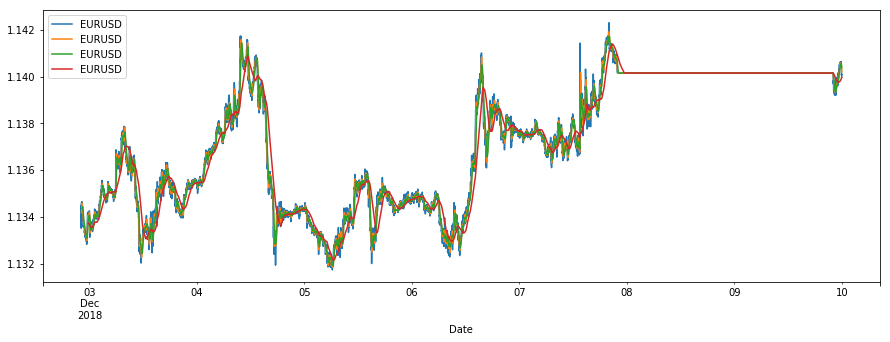

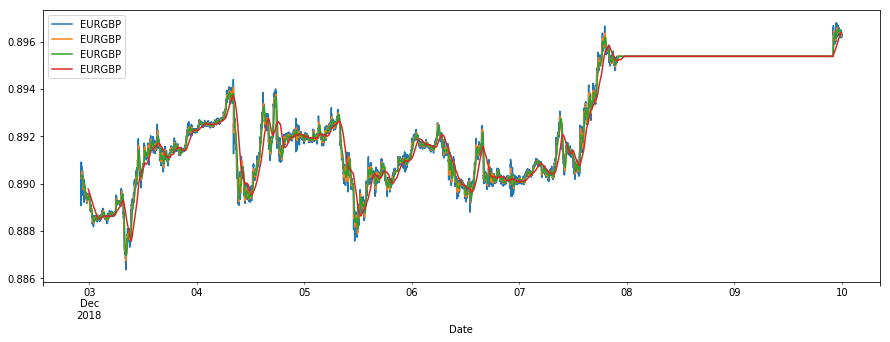

In [23]:

def run(selected_tickers, start=None, end=None):
    
    #t1 = pairs('jmt:pl', 'galp:pl', dependent=True, name='jmt_pairs')
    #t2 = pairs('jmt:pl', 'galp:pl', dependent=False, name='galp_pairs')
    t1 = ma_cross('EURUSD', name='eurusd_ma_cross', start='2018-12-1', end='2018-12-10')
    t2 = ma_cross('EURGBP', name='eurgbp_ma_cross', start='2018-12-1', end='2018-12-10')
    #t1 = ma_cross('sonc:pl', name='sonc_ma_cross')
    #t2 = ma_cross('rene:pl', name='rene_ma_cross')
    #t3 = ma_cross('edp:pl', name='edp_ma_cross')
    #t4 = ma_cross('scp:pl', name='scp_ma_cross')
    
    # let's run these strategies now
    return bt.run(t1, t2)
    

res = run(['galp:pl'])

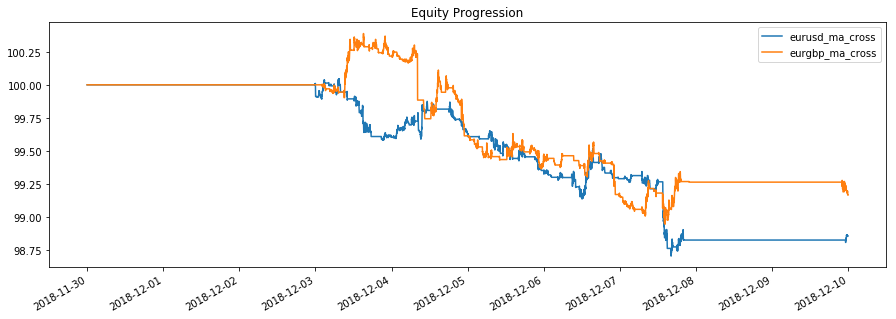

In [24]:
%matplotlib inline 
res.plot()

In [25]:
res.display()

Stat                 eurusd_ma_cross    eurgbp_ma_cross
-------------------  -----------------  -----------------
Start                2018-11-30         2018-11-30
End                  2018-12-09         2018-12-09
Risk-free rate       0.00%              0.00%

Total Return         -1.14%             -0.83%
Daily Sharpe         -10.09             -6.07
Daily Sortino        -10.42             -7.13
CAGR                 -37.31%            -28.82%
Max Drawdown         -1.19%             -1.06%
Calmar Ratio         -31.47             -27.31

MTD                  -1.14%             -0.83%
3m                   -                  -
6m                   -                  -
YTD                  -1.14%             -0.83%
1Y                   -                  -
3Y (ann.)            -                  -
5Y (ann.)            -                  -
10Y (ann.)           -                  -
Since Incep. (ann.)  -37.31%            -28.82%

Daily Sharpe         -10.09             -6.07
Daily Sortino 

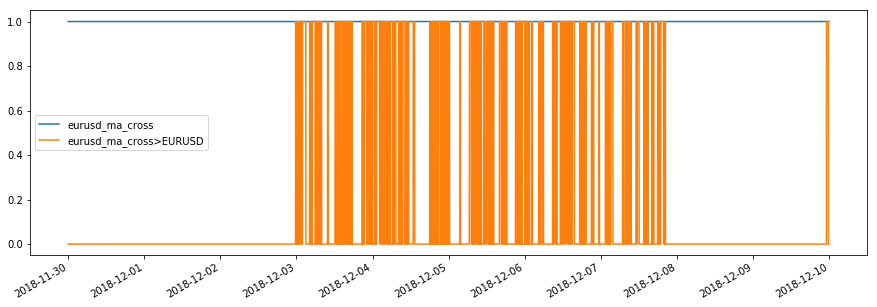

In [29]:
res.plot_weights()

In [26]:
trades = res.get_transactions(strategy_name='eurgbp_ma_cross')
#trades['price']['Date']
trades = np.sign(trades.unstack()['quantity'])
long_trades = trades[trades>0].dropna()
short_trades = trades[trades<0].dropna()
#print(long_trades.index & data.index)
import bqplot.pyplot as plt
data = load_data('EURGBP',start='2018-12-1', end='2018-12-10', remote=True)
#sns.lmplot(data=data['EURGBP'])
#plt.plot(data.index, data['EURGBP'], label="Strike", alpha=0.4)
#plt.plot(long_trades.index,data.loc[long_trades.index & data.index], marker='triangle-up' ,label="Strike", alpha=0.4)
#plt.plot(short_trades.index,data.loc[short_trades.index & data.index],marker='triangle-down', label="Strike", alpha=0.4)
#plt.show()

from bokeh.models import HoverTool, ColumnDataSource, BoxZoomTool
from bokeh.models.ranges import Range1d
from bokeh.models.axes import LinearAxis
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
tools = ['reset', 'box_select', 'pan', 'zoom_out', 'wheel_zoom']
p1 = figure(tools=tools, x_axis_type="datetime", title='EURGBP', plot_width=1000)
p1.line(data.index, data['EURGBP'], color='blue', legend='price')
p1.triangle(long_trades.index,data['EURGBP'].loc[long_trades.index & data.index], color='green', size=10, legend='BUY')
p1.inverted_triangle(short_trades.index,data['EURGBP'].loc[short_trades.index & data.index], color='red', size=10, legend='SELL')

show(p1)